In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy import interpolate

import os
import time

from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import FormatStrFormatter
from matplotlib.animation import FuncAnimation

import seaborn as sns
import json

In [2]:
# Enable interactive plot
%matplotlib notebook

In [3]:
from cosmo_bbh_tools import cosmo_bbh_tools as cbt

In [4]:
n_systems_all = [5e1, 5e2, 5e3, 5e4, 5e5, 5e6]
n_systems = n_systems_all[:]
print(n_systems)

zminn = 0.000100 # COMPAS MIN
zmaxx = 0.030000 # COMPAS MAX
Z_MIN_LOG = np.log10(zminn)
Z_MAX_LOG = np.log10(zmaxx)

metallicities = np.logspace(Z_MIN_LOG, Z_MAX_LOG, 10)
print(metallicities)

[50.0, 500.0, 5000.0, 50000.0, 500000.0, 5000000.0]
[0.0001     0.00018847 0.0003552  0.00066943 0.00126166 0.00237782
 0.0044814  0.00844598 0.01591789 0.03      ]


# Read raw data

In [5]:
raw_dir = "raw_data"
fname = "sfm"
with open(f"{raw_dir}/{fname}",'r') as infile:
    sfm = json.load(infile)

In [6]:
fname = "M1_BBH_ALL"
with open(f"{raw_dir}/{fname}",'r') as infile:
    M1_BBH_ALL = json.load(infile)

# Getting BBHs from SFM, Metallicity

In [7]:
met_dir = "bbh_by_met"
fname = f"M1_BBH_METS"
with open(f"{met_dir}/{fname}",'r') as infile:
    M1_BBH_METS = json.load(infile)
    
fname = f"M2_BBH_METS"
with open(f"{met_dir}/{fname}",'r') as infile:
    M2_BBH_METS = json.load(infile)
    
fname = f"DELAY_TIMES_METS"
with open(f"{met_dir}/{fname}",'r') as infile:
    DELAY_TIMES_METS = json.load(infile)

# Animations

In [8]:
met_sfm_to_n_bbh = cbt.interpolate_n_bbh(sfm, metallicities, M1_BBH_ALL)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import mpl_toolkits.axes_grid1
import matplotlib.widgets

class Player(FuncAnimation):
    def __init__(self, fig, func, frames=None, init_func=None, fargs=None,
                 save_count=None, mini=0, maxi=100, pos=(0.125, 0.92), **kwargs):
        self.i = 0
        self.min=mini
        self.max=maxi
        self.runs = True
        self.forwards = True
        self.fig = fig
        self.func = func
        self.setup(pos)
        FuncAnimation.__init__(self,self.fig, self.update, frames=self.play(), 
                                           init_func=init_func, fargs=fargs,
                                           save_count=save_count, **kwargs )    

    def play(self):
        while self.runs:
            self.i = self.i+self.forwards-(not self.forwards)
            if self.i > self.min and self.i < self.max:
                yield self.i
            else:
                self.stop()
                yield self.i

    def start(self):
        self.runs=True
        self.event_source.start()

    def stop(self, event=None):
        self.runs = False
        self.event_source.stop()

    def forward(self, event=None):
        self.forwards = True
        self.start()
    def backward(self, event=None):
        self.forwards = False
        self.start()
    def oneforward(self, event=None):
        self.forwards = True
        self.onestep()
    def onebackward(self, event=None):
        self.forwards = False
        self.onestep()

    def onestep(self):
        if self.i > self.min and self.i < self.max:
            self.i = self.i+self.forwards-(not self.forwards)
        elif self.i == self.min and self.forwards:
            self.i+=1
        elif self.i == self.max and not self.forwards:
            self.i-=1
        self.func(self.i)
        self.slider.set_val(self.i)
        self.fig.canvas.draw_idle()

    def setup(self, pos):
        playerax = self.fig.add_axes([pos[0],pos[1], 0.64, 0.04])
        divider = mpl_toolkits.axes_grid1.make_axes_locatable(playerax)
        bax = divider.append_axes("right", size="80%", pad=0.05)
        sax = divider.append_axes("right", size="80%", pad=0.05)
        fax = divider.append_axes("right", size="80%", pad=0.05)
        ofax = divider.append_axes("right", size="100%", pad=0.05)
        sliderax = divider.append_axes("right", size="500%", pad=0.07)
        self.button_oneback = matplotlib.widgets.Button(playerax, label='$\u29CF$')
        self.button_back = matplotlib.widgets.Button(bax, label='$\u25C0$')
        self.button_stop = matplotlib.widgets.Button(sax, label='$\u25A0$')
        self.button_forward = matplotlib.widgets.Button(fax, label='$\u25B6$')
        self.button_oneforward = matplotlib.widgets.Button(ofax, label='$\u29D0$')
        self.button_oneback.on_clicked(self.onebackward)
        self.button_back.on_clicked(self.backward)
        self.button_stop.on_clicked(self.stop)
        self.button_forward.on_clicked(self.forward)
        self.button_oneforward.on_clicked(self.oneforward)
        self.slider = matplotlib.widgets.Slider(sliderax, '', 
                                                self.min, self.max, valinit=self.i)
        self.slider.on_changed(self.set_pos)

    def set_pos(self,i):
        self.i = int(self.slider.val)
        self.func(self.i)

    def update(self,i):
        self.slider.set_val(i)


In [43]:
n_met = 50
# met_plot_range = np.logspace(Z_MIN_LOG, Z_MAX_LOG, n_met)
met_plot_range = np.linspace(zminn, zmaxx, n_met)
SFM = 8.7e7
m1_samples = []
m2_samples = []
m1_samples_trim = []
m2_samples_trim = []

dt_samples = []

In [44]:
for i in range(len(met_plot_range)):
    MET = met_plot_range[i]
    M1_SAMPLED, M2_SAMPLED, DELAY_TIME_SAMPLED = cbt.sample_bbh_from_sfm_met(SFM, MET, sfm, metallicities, met_sfm_to_n_bbh, M1_BBH_METS, M2_BBH_METS, DELAY_TIMES_METS)
    M1_SAMPLED_TRIMMED = [x for x in M1_SAMPLED if x <= 50.] # trim values larger than 50 M_sol for plotting
    M2_SAMPLED_TRIMMED = [x for x in M2_SAMPLED if x <= 50.] # trim values larger than 50 M_sol for plotting
    
    m1_samples.append(M1_SAMPLED)
    m2_samples.append(M2_SAMPLED)
    
    m1_samples_trim.append(M1_SAMPLED_TRIMMED)
    m2_samples_trim.append(M2_SAMPLED_TRIMMED)
    
    dt_samples.append(DELAY_TIME_SAMPLED)
    

<IPython.core.display.Javascript object>


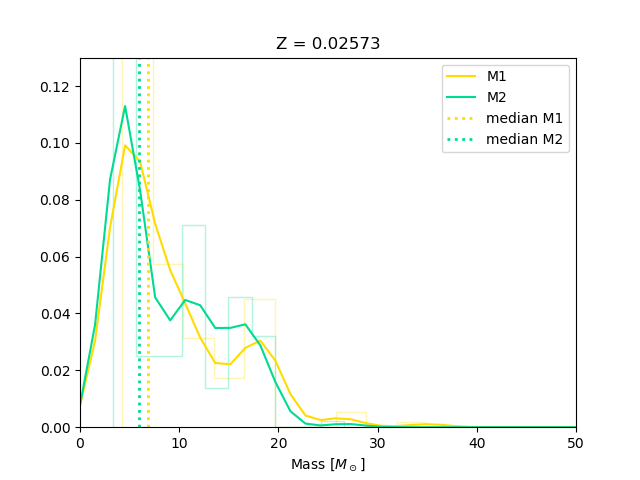

In [51]:
import matplotlib.animation as animation
import matplotlib.pylab as pl

colors_m1 = pl.cm.autumn(np.linspace(0,1,n_met))
colors_m2 = pl.cm.winter(np.linspace(0,1,n_met))

import cycler


def update_hist(num, data_m1, data_m2):
    plt.cla()
    plt.hist(data_m1[num], histtype='step', density=True, color=colors_m1[num], label='M1')
    plt.hist(data_m2[num], histtype='step', density=True, color=colors_m2[num], label='M2')
    plt.axvline(x=np.mean(data_m1[num]), color=colors_m1[num], ls=':', lw=2, label='median M1')
    plt.axvline(x=np.mean(data_m2[num]), color=colors_m2[num], ls=':', lw=2, label='median M2')
    
    plt.title(f'Z = {met_plot_range[num]:.5f}')
    plt.legend()
    plt.xlim(0, 150)
    plt.ylim(0, 0.13)
    plt.xlabel("Mass $M_\odot$")


fig = plt.figure()

plt.xlim(0, 150)
plt.ylim(0, 0.13)
plt.xlabel("Mass $M_\odot$")

hist1 = plt.hist(m1_samples[0], histtype='step', density=True, label='M1')
hist2 = plt.hist(m2_samples[0], histtype='step', density=True, label='M2')
plt.legend()

animation = animation.FuncAnimation(fig, update_hist, n_met, fargs=(m1_samples, m2_samples) )


plt.show()

In [45]:
from scipy.stats.kde import gaussian_kde
from numpy import linspace

def plot_kde(M1, M2, xlabel="Primary Mass [$M_\odot$]", N_kde = 100, color_m1='b', color_m2='r'):
    kde_m1 = gaussian_kde( M1 )
    kde_dist_space_m1 = linspace(0,150, N_kde)    
    plt.plot( kde_dist_space_m1, kde_m1(kde_dist_space_m1), color=color_m1, label='M1')
    
    kde_m2 = gaussian_kde( M2 )
    kde_dist_space_m2 = linspace(0,150, N_kde)    
    plt.plot( kde_dist_space_m2, kde_m2(kde_dist_space_m2), color=color_m2, label='M2')
    
    plt.axvline(x=np.median(M1), color=color_m1, ls=':', lw=2, label='median M1')
    plt.axvline(x=np.median(M2), color=color_m2, ls=':', lw=2, label='median M2')

    
    plt.legend()

<IPython.core.display.Javascript object>


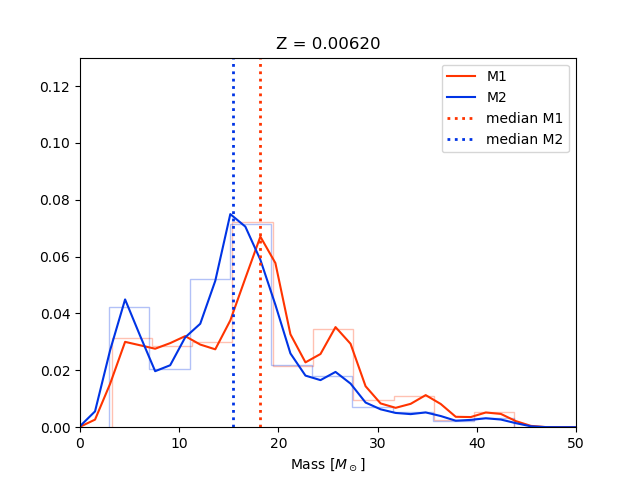

In [52]:
import matplotlib.animation as animation
import matplotlib.pylab as pl

colors_m1 = pl.cm.autumn(np.linspace(0,1,n_met))
colors_m2 = pl.cm.winter(np.linspace(0,1,n_met))

import cycler



def update_hist(num, data_m1, data_m2):
    plt.cla()
    plot_kde(data_m1[num], data_m2[num], color_m1=colors_m1[num], color_m2 =colors_m2[num])
    
    plt.hist(data_m1[num], histtype='step', density=True, color=colors_m1[num], alpha=0.3)
    plt.hist(data_m2[num], histtype='step', density=True, color=colors_m2[num], alpha=0.3)
    plt.title(f'Z = {met_plot_range[num]:.5f}')
    plt.xlim(0, 50)
    plt.ylim(0, 0.13)
    plt.xlabel("Mass [$M_\odot$]")


fig = plt.figure()

plt.xlim(0, 50)
plt.ylim(0, 0.13)
plt.xlabel("Mass [$M_\odot$]")

# hist = plot_kde(m1_samples[0], m2_samples[0], color_m1=colors_m1[0], color_m2=colors_m2[0] )
# animation = animation.FuncAnimation(fig, update_hist, n_met, fargs=(m1_samples, m2_samples) )

hist = plot_kde(m1_samples_trim[0], m2_samples_trim[0], color_m1=colors_m1[0], color_m2=colors_m2[0] )
animation = animation.FuncAnimation(fig, update_hist, n_met, fargs=(m1_samples_trim, m2_samples_trim) )


plt.show()

# Delay Time

In [18]:
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
H0 = cosmo.H(0)
t0 = 1.0/H0
t0_Myr = t0.decompose().to(u.Myr)
T_HUBBLE_MYR = t0_Myr.value
print(T_HUBBLE_MYR)

14105.485021361645


<IPython.core.display.Javascript object>


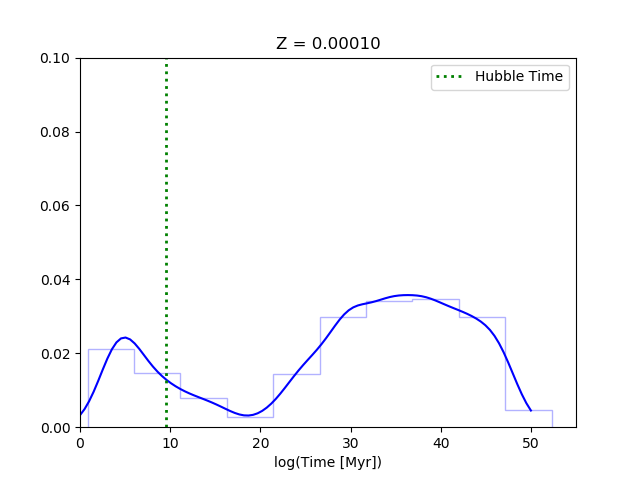

In [41]:
import matplotlib.animation as animation
import matplotlib.pylab as pl

colors_dt = pl.cm.winter(np.linspace(0,1,n_met))



def update_hist(num, data_dt):
    plt.cla()
    kde_dt = gaussian_kde(np.log(data_dt[num]))
    kde_dist = np.linspace(0,50, 100)
    plt.plot(kde_dist, kde_dt(kde_dist), color=colors_dt[num])
    plt.hist(np.log(data_dt[num]), histtype='step', density=True, alpha=0.3, color=colors_dt[num])

    plt.axvline(x=np.log(T_HUBBLE_MYR), color='g', ls=':', lw=2, label='Hubble Time')
    
    plt.title(f'Z = {met_plot_range[num]:.5f}')
    plt.legend()
    plt.xlim(0, 55)
    plt.ylim(0, 0.1)
    plt.xlabel("log(Time [Myr])")


fig = plt.figure()

plt.xlim(0, 55)
plt.ylim(0, 0.1)
plt.xlabel("log(Time [Myr])")

hist1 = plt.hist(np.log(dt_samples[0]), histtype='step', density=True)
plt.axvline(x=np.log(T_HUBBLE_MYR), color='g', ls=':', lw=2, label='Hubble Time')
plt.legend()

animation = animation.FuncAnimation(fig, update_hist, n_met, fargs=(dt_samples,) )


plt.show()